In [1]:
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import xarray as xr
import math

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

D:\Conda\envs\test_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Running Model with RCIMP

In [2]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, 2300, 1)  # start, end, step

"""
scenarios = [
    "high-extension",
    "high-overshoot",
    "medium-overshoot",
    "medium-extension",
    "low",
    "verylow",
    "verylow-overshoot",
]
"""

scenarios_Rcimp = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp434', 'ssp460', 'ssp534-over', 'ssp585']
f.define_scenarios(scenarios_Rcimp)
fair_params_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)
fair_species_configs_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
species_Rcimp, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f.define_species(species_Rcimp, properties)
f.allocate()
"""
f.fill_from_csv(
    emissions_file='examples/data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='examples/data/calibrated_constrained_ensemble/volcanic_solar.csv',
)
"""
f.fill_from_rcmip()


f.forcing.sel(specie="Volcanic")
fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
f.fill_species_configs(fair_species_configs_1_4_1_file)
f.override_defaults(fair_params_1_4_1_file)
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)
f.run()



Running 6728 projections in parallel: 100%|██████████| 550/550 [00:48<00:00, 11.39timesteps/s]


Running model with data from calibrated ensenbles

In [3]:
f2 = FAIR(ch4_method="Thornhill2021")
f2.define_time(1750, 2300, 1)  # start, end, step
scenarios_data = [
    "high-extension",
    "high-overshoot",
    "medium-overshoot",
    "medium-extension",
    "low",
    "verylow",
    "verylow-overshoot",
]
f2.define_scenarios(scenarios_data)
fair_params_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f2.define_configs(configs)
fair_species_configs_1_4_1_file = 'examples/data/calibrated_constrained_ensemble/species_configs_properties_calibration1.4.1.csv'
species_data, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f2.define_species(species_data, properties)
f2.allocate()
f2.fill_from_csv(
    emissions_file='examples/data/calibrated_constrained_ensemble/extensions_1750-2500.csv',
    forcing_file='examples/data/calibrated_constrained_ensemble/volcanic_solar.csv',
)


f2.forcing.sel(specie="Volcanic")
fill(
    f2.forcing,
    f2.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f2.forcing,
    f2.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)
f2.fill_species_configs(fair_species_configs_1_4_1_file)
f2.override_defaults(fair_params_1_4_1_file)
initialise(f2.concentration, f2.species_configs["baseline_concentration"])
initialise(f2.forcing, 0)
initialise(f2.temperature, 0)
initialise(f2.cumulative_emissions, 0)
initialise(f2.airborne_emissions, 0)
initialise(f2.ocean_heat_content_change, 0)
f2.run()



Running 5887 projections in parallel: 100%|██████████| 550/550 [00:45<00:00, 12.05timesteps/s]


# Adding 4 new species for forcing calculation

- Finding max forcing, average each config, report STDV as error
- Writing into the Rcimp max forcing df
- ariNH3  shape=(550, 8, 841) (years, scenarios, configs)

## For RCIMP data

In [76]:
ariNH3 = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    ariNH3[:,:,i] = df_configs["erfari_radiative_efficiency[NH3]"].iloc[i]*(f.emissions.loc[dict(specie='NH3')][:,:,i]-f.emissions.loc[dict(specie='NH3')][0,:,i])

o3CO = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3CO[:,:,i] = df_configs["ozone_radiative_efficiency[CO]"].iloc[i]*(f.emissions.loc[dict(specie='CO')][:,:,i]-f.emissions.loc[dict(specie='CO')][0,:,i])

o3VOC = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3VOC[:,:,i] = (df_configs["ozone_radiative_efficiency[VOC]"].iloc[i] + df_configs["erfari_radiative_efficiency[VOC]"].iloc[i])*(f.emissions.loc[dict(specie='VOC')][:,:,i]-f.emissions.loc[dict(specie='VOC')][0,:,i])

o3ariNOx = np.zeros((np.size(f.timepoints),np.size(scenarios_Rcimp),np.size(configs)))
for i in range(np.size(configs)):
    o3ariNOx[:,:,i] = (df_configs["ozone_radiative_efficiency[NOx]"].iloc[i]+df_configs["erfari_radiative_efficiency[NOx]"].iloc[i])*(f.emissions.loc[dict(specie='NOx')][:,:,i]-f.emissions.loc[dict(specie='NOx')][0,:,i])

In [78]:
ariNH3

array([[[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        ...,
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]],

       [[ 4.58085585e-05,  4.28842745e-05,  3.86332821e-05, ...,
          4.13845759e-05,  3.89011771e-05,  4.09980668e-05],
        [ 4.58085585e-05,  4.28842745e-05,  3.86332821e-05, ...,
          4.13845759e-05,  3.89011771e

In [79]:
def to_darray(specie_array, specie_name, model):
    # trim the shape, add 0
    specie_array_resized = np.zeros((551, len(model.forcing['scenario']), 841))
    original_shape = specie_array.shape
    specie_array_resized[:original_shape[0], :original_shape[1], :original_shape[2]] = specie_array

    specie_darray = xr.DataArray(
    specie_array_resized,
    dims=['timebounds', 'scenario', 'config'],
    coords={
        'timebounds': model.forcing.coords['timebounds'].values,
        'scenario': model.forcing.coords['scenario'].values,
        'config': model.forcing.coords['config'].values
    },
    name=specie_name)

    specie_darray = specie_darray.expand_dims({"specie": [specie_name]})
    return specie_darray

ariNH3_da = to_darray(ariNH3, 'ariNH3', f)
o3VOC_da = to_darray(o3VOC, 'o3VOC', f)
o3CO_da = to_darray(o3CO, 'o3CO', f)
o3ariNOx_da = to_darray(o3ariNOx, 'o3ariNOx', f)

Neg_ariNH3_da = to_darray(-ariNH3, 'Neg_ariNH3', f)
Neg_o3VOC_da = to_darray(-o3VOC, 'Neg_o3VOC', f)
Neg_o3CO_da = to_darray(-o3CO, 'Neg_o3CO', f)
Neg_o3ariNOx_da = to_darray(-o3ariNOx, 'Neg_o3ariNOx', f)


forcing_clone = f.forcing.copy()
forcing_clone = xr.concat([forcing_clone, ariNH3_da, o3CO_da, o3VOC_da, o3ariNOx_da, Neg_ariNH3_da, Neg_o3CO_da, Neg_o3VOC_da, Neg_o3ariNOx_da], dim="specie")
forcing_clone.specie

<xarray.DataArray 'specie' (specie: 69)> Size: 552B
array(['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O', 'Sulfur', 'BC', 'OC',
       'NH3', 'NOx', 'VOC', 'CO', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114',
       'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CCl4', 'CHCl3',
       'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301',
       'Halon-2402', 'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12',
       'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC-125', 'HFC-134a',
       'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'Solar', 'Volcanic',
       'Aerosol-radiation interactions', 'Aerosol-cloud interactions', 'Ozone',
       'Light absorbing particles on snow and ice',
       'Stratospheric water vapour', 'Land use',
       'Equivalent effective stratospheric chlorine', 'ariNH3', 'o3CO',
       'o3VOC', 'o3ariNOx', 'Neg_ariNH3', 'Neg_o3CO', 'Neg_o3VOC',
       'Neg_o3ariNOx'], dtype=object)
Coordinates:
  * specie   (specie) object 552B 'CO2 FFI' 'CO2 AFOLU' ... 'Neg_o3ariNOx'

In [80]:
max_forcing = forcing_clone.max(dim='timebounds')
idx = forcing_clone.argmax(dim='timebounds')
max_forcing_year = forcing_clone['timebounds'].isel(timebounds=idx)

ds1 = xr.Dataset({
    'max_forcing':       max_forcing,
    'max_forcing_year':  max_forcing_year
})
df1 = ds1.to_dataframe().reset_index()

df1['config']            = df1['config'].astype(int)
df1['max_forcing_year']  = df1['max_forcing_year'].astype(int)
df1.drop(columns=['timebounds'], inplace=True)
df1.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_Rcimp.csv',
          index=False)

In [81]:
df1[df1['specie'] == 'Neg_ariNH3']

,scenario,config,specie,max_forcing,max_forcing_year
65,ssp119,1234,Neg_ariNH3,0.03957,2015
134,ssp119,2451,Neg_ariNH3,0.03705,2015
203,ssp119,5859,Neg_ariNH3,0.03337,2015
272,ssp119,5883,Neg_ariNH3,0.03574,2015
341,ssp119,14573,Neg_ariNH3,0.03681,2015
...,...,...,...,...,...
463952,ssp585,1590667,Neg_ariNH3,0.04643,2070
464021,ssp585,1590821,Neg_ariNH3,0.04911,2070
464090,ssp585,1592589,Neg_ariNH3,0.04798,2070
464159,ssp585,1594247,Neg_ariNH3,0.04510,2070


## for 7 scenario in extension 1750-2500

In [82]:
ariNH3_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    ariNH3_f2[:,:,i] = df_configs["erfari_radiative_efficiency[NH3]"].iloc[i]*(f2.emissions.loc[dict(specie='NH3')][:,:,i]-f2.emissions.loc[dict(specie='NH3')][0,:,i])

o3CO_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    o3CO_f2[:,:,i] = df_configs["ozone_radiative_efficiency[CO]"].iloc[i]*(f2.emissions.loc[dict(specie='CO')][:,:,i]-f2.emissions.loc[dict(specie='CO')][0,:,i])

o3VOC_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    o3VOC_f2[:,:,i] = (df_configs["ozone_radiative_efficiency[VOC]"].iloc[i] + df_configs["erfari_radiative_efficiency[VOC]"].iloc[i])*(f2.emissions.loc[dict(specie='VOC')][:,:,i]-f2.emissions.loc[dict(specie='VOC')][0,:,i])

o3ariNOx_f2 = np.zeros((np.size(f2.timepoints),7,np.size(configs)))
for i in range(np.size(configs)):
    o3ariNOx_f2[:,:,i] = (df_configs["ozone_radiative_efficiency[NOx]"].iloc[i]+df_configs["erfari_radiative_efficiency[NOx]"].iloc[i])*(f2.emissions.loc[dict(specie='NOx')][:,:,i]-f2.emissions.loc[dict(specie='NOx')][0,:,i])

In [84]:
ariNH3_da_f2 = to_darray(ariNH3_f2, 'ariNH3', f2)
o3VOC_da_f2 = to_darray(o3VOC_f2, 'o3VOC', f2)
o3CO_da_f2 = to_darray(o3CO_f2, 'o3CO', f2)
o3ariNOx_da_f2 = to_darray(o3ariNOx_f2, 'o3ariNOx', f2)

Neg_ariNH3_da_f2 = to_darray(-ariNH3_f2, 'Neg_ariNH3', f2)
Neg_o3VOC_da_f2 = to_darray(-o3VOC_f2, 'Neg_o3VOC', f2)
Neg_o3CO_da_f2 = to_darray(-o3CO_f2, 'Neg_o3CO', f2)
Neg_o3ariNOx_da_f2 = to_darray(-o3ariNOx_f2, 'Neg_o3ariNOx', f2)


forcing_clone_f2 = f2.forcing.copy()
forcing_clone_f2 = xr.concat([forcing_clone_f2, ariNH3_da_f2, o3CO_da_f2, o3VOC_da_f2, o3ariNOx_da_f2, Neg_ariNH3_da_f2, Neg_o3CO_da_f2, Neg_o3VOC_da_f2, Neg_o3ariNOx_da_f2], dim="specie")
forcing_clone_f2.specie

<xarray.DataArray 'specie' (specie: 69)> Size: 552B
array(['CO2 FFI', 'CO2 AFOLU', 'CO2', 'CH4', 'N2O', 'Sulfur', 'BC', 'OC',
       'NH3', 'NOx', 'VOC', 'CO', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114',
       'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b', 'CCl4', 'CHCl3',
       'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301',
       'Halon-2402', 'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12',
       'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2', 'HFC-125', 'HFC-134a',
       'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-4310mee', 'Solar', 'Volcanic',
       'Aerosol-radiation interactions', 'Aerosol-cloud interactions', 'Ozone',
       'Light absorbing particles on snow and ice',
       'Stratospheric water vapour', 'Land use',
       'Equivalent effective stratospheric chlorine', 'ariNH3', 'o3CO',
       'o3VOC', 'o3ariNOx', 'Neg_ariNH3', 'Neg_o3CO', 'Neg_o3VOC',
       'Neg_o3ariNOx'], dtype=object)
Coordinates:
  * specie   (specie) object 552B 'CO2 FFI' 'CO2 AFOLU' ... 'Neg_o3ariNOx'

In [85]:
max_forcing = forcing_clone_f2.max(dim='timebounds')
idx = forcing_clone_f2.argmax(dim='timebounds')
max_forcing_year = forcing_clone_f2['timebounds'].isel(timebounds=idx)

ds2 = xr.Dataset({
    'max_forcing':       max_forcing,
    'max_forcing_year':  max_forcing_year
})
df2 = ds2.to_dataframe().reset_index()

df2['config']            = df2['config'].astype(int)
df2['max_forcing_year']  = df2['max_forcing_year'].astype(int)
df2.drop(columns=['timebounds'], inplace=True)
df2.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_cali.csv',
          index=False)

In [86]:
df2[df2['specie'] == 'Neg_ariNH3']

,scenario,config,specie,max_forcing,max_forcing_year
65,high-extension,1234,Neg_ariNH3,0.05537,2100
134,high-extension,2451,Neg_ariNH3,0.05184,2100
203,high-extension,5859,Neg_ariNH3,0.04670,2100
272,high-extension,5883,Neg_ariNH3,0.05002,2100
341,high-extension,14573,Neg_ariNH3,0.05152,2100
...,...,...,...,...,...
405923,verylow-overshoot,1590667,Neg_ariNH3,0.03542,2021
405992,verylow-overshoot,1590821,Neg_ariNH3,0.03746,2021
406061,verylow-overshoot,1592589,Neg_ariNH3,0.03660,2021
406130,verylow-overshoot,1594247,Neg_ariNH3,0.03441,2021


# Find out average max forcing a range of year

In [87]:
def summarize_forcing(forcing_df):
    summary_df = (forcing_df.groupby(['scenario', 'specie'])
                  .agg({'max_forcing': ['mean', 'std'],
                        'max_forcing_year': lambda x: (min(x), max(x))})
                  .reset_index())
    summary_df.columns = ['scenario', 'specie', 'mean_max_forcing', 'max_forcing_std', 'max_forcing_year']
    summary_df[['min_year', 'max_year']] = pd.DataFrame(summary_df['max_forcing_year'].tolist(), index=summary_df.index)
    summary_df['year_range'] = summary_df['max_year'] - summary_df['min_year']
    summary_df["std_by_scenario"] = summary_df.groupby('specie')['mean_max_forcing'].transform('std')
    summary_df["mean_by_scenario"] = summary_df.groupby('specie')['mean_max_forcing'].transform('mean')
    summary_df["cv_by_scenario"] = (summary_df["std_by_scenario"]/summary_df["mean_by_scenario"]).fillna(0)
    summary_df.drop(columns=["std_by_scenario", "mean_by_scenario", 'max_forcing_year'], inplace=True)

    return summary_df

summary_rcimp = summarize_forcing(df1)
summary_cali = summarize_forcing(df2)

In [88]:
summary_cali[summary_cali['specie'] == 'Neg_ariNH3']

,scenario,specie,mean_max_forcing,max_forcing_std,min_year,max_year,year_range,cv_by_scenario
51,high-extension,Neg_ariNH3,0.05075,0.00342,2100,2100,0,0.14362
120,high-overshoot,Neg_ariNH3,0.05075,0.00342,2100,2100,0,0.14362
189,low,Neg_ariNH3,0.03713,0.00251,2021,2021,0,0.14362
258,medium-extension,Neg_ariNH3,0.04208,0.00284,2050,2050,0,0.14362
327,medium-overshoot,Neg_ariNH3,0.04208,0.00284,2050,2050,0,0.14362
396,verylow,Neg_ariNH3,0.03713,0.00251,2021,2021,0,0.14362
465,verylow-overshoot,Neg_ariNH3,0.03713,0.00251,2021,2021,0,0.14362


In [89]:
summary_rcimp[summary_rcimp['specie'] == 'Neg_ariNH3']

,scenario,specie,mean_max_forcing,max_forcing_std,min_year,max_year,year_range,cv_by_scenario
51,ssp119,Neg_ariNH3,0.03627,0.00245,2015,2015,0,0.19561
120,ssp126,Neg_ariNH3,0.03627,0.00245,2015,2015,0,0.19561
189,ssp245,Neg_ariNH3,0.04295,0.00290,2050,2050,0,0.19561
258,ssp370,Neg_ariNH3,0.05058,0.00341,2100,2100,0,0.19561
327,ssp434,Neg_ariNH3,0.05731,0.00387,2080,2080,0,0.19561
396,ssp460,Neg_ariNH3,0.06228,0.00420,2100,2100,0,0.19561
465,ssp534-over,Neg_ariNH3,0.05384,0.00363,2090,2090,0,0.19561
534,ssp585,Neg_ariNH3,0.04868,0.00328,2070,2070,0,0.19561


In [90]:
summary_rcimp.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_summary_Rcimp.csv')
summary_cali.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_summary_Cali.csv')

method for plotting

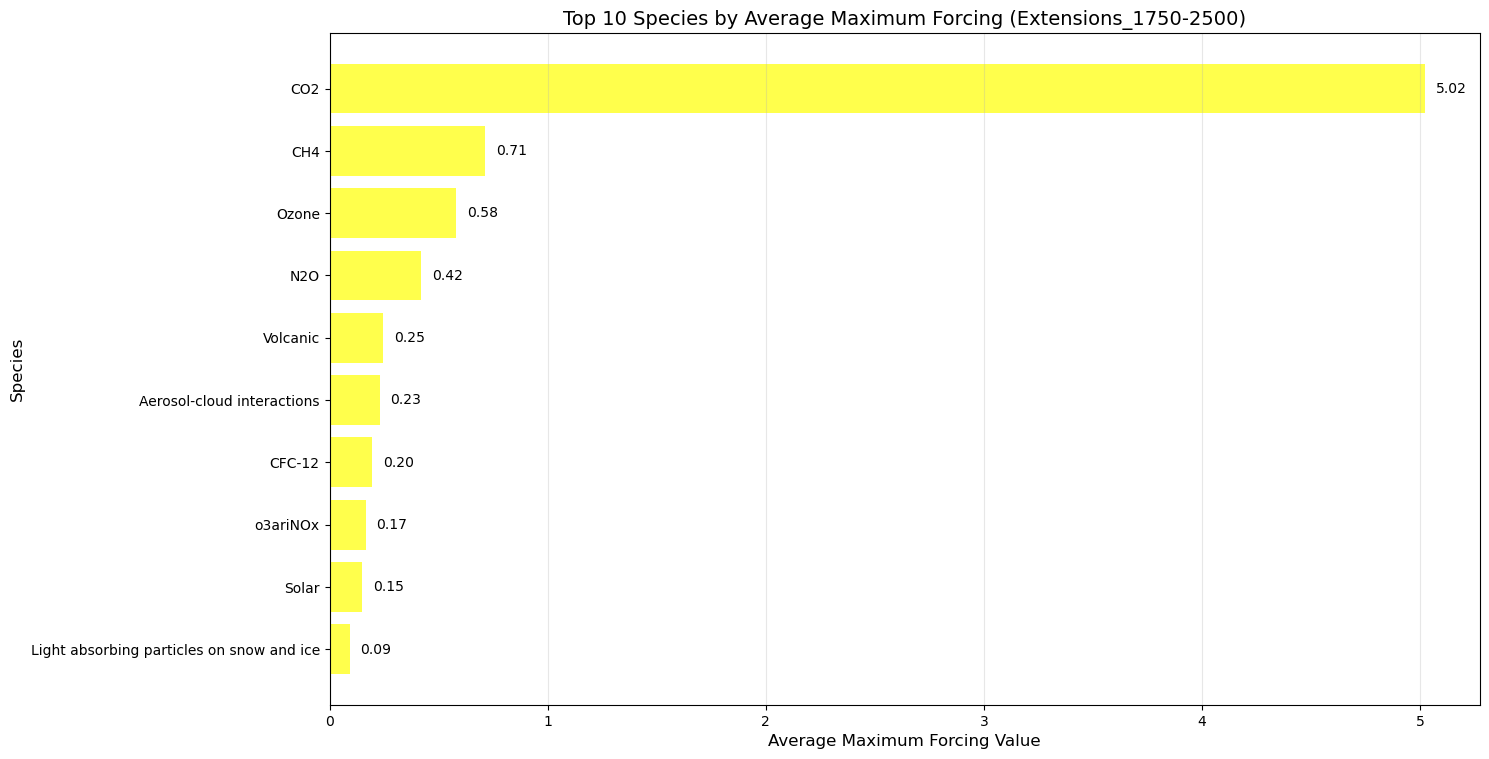

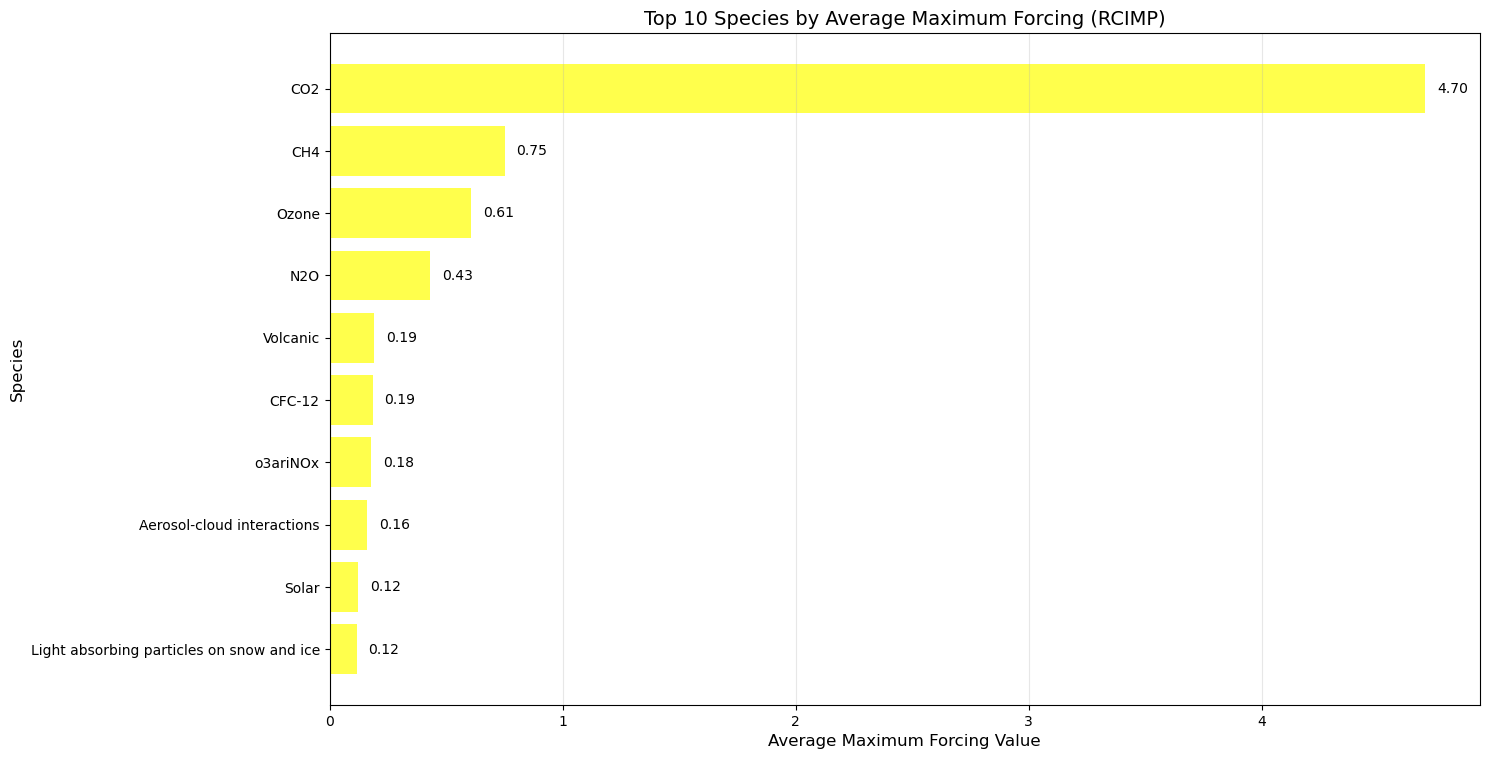

In [91]:
def plot_top(ploting_df, top_number, title_suffix):
    if top_number > ploting_df.nunique()['specie']:
        top_number = ploting_df.nunique()['specie']

    top_species = ploting_df.groupby('specie')['mean_max_forcing'].mean().nlargest(top_number).sort_values(ascending=True)

    pl.figure(figsize=(15, top_number/1.3))
    bars = pl.barh(top_species.index, top_species.values, color='yellow', alpha=0.7)
    pl.xlabel('Average Maximum Forcing Value', fontsize=12)
    pl.ylabel('Species', fontsize=12)
    title = 'Top {} Species by Average Maximum Forcing '.format(top_number) + title_suffix
    pl.title(title, fontsize=14)
    pl.grid(axis='x', alpha=0.3)

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        pl.text(width + 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
                 ha='left', va='center', fontsize=10)

    pl.tight_layout()
    pl.show()

plot_top(summary_cali, 10, '(Extensions_1750-2500)')
plot_top(summary_rcimp, 10, '(RCIMP)')

# Ranking

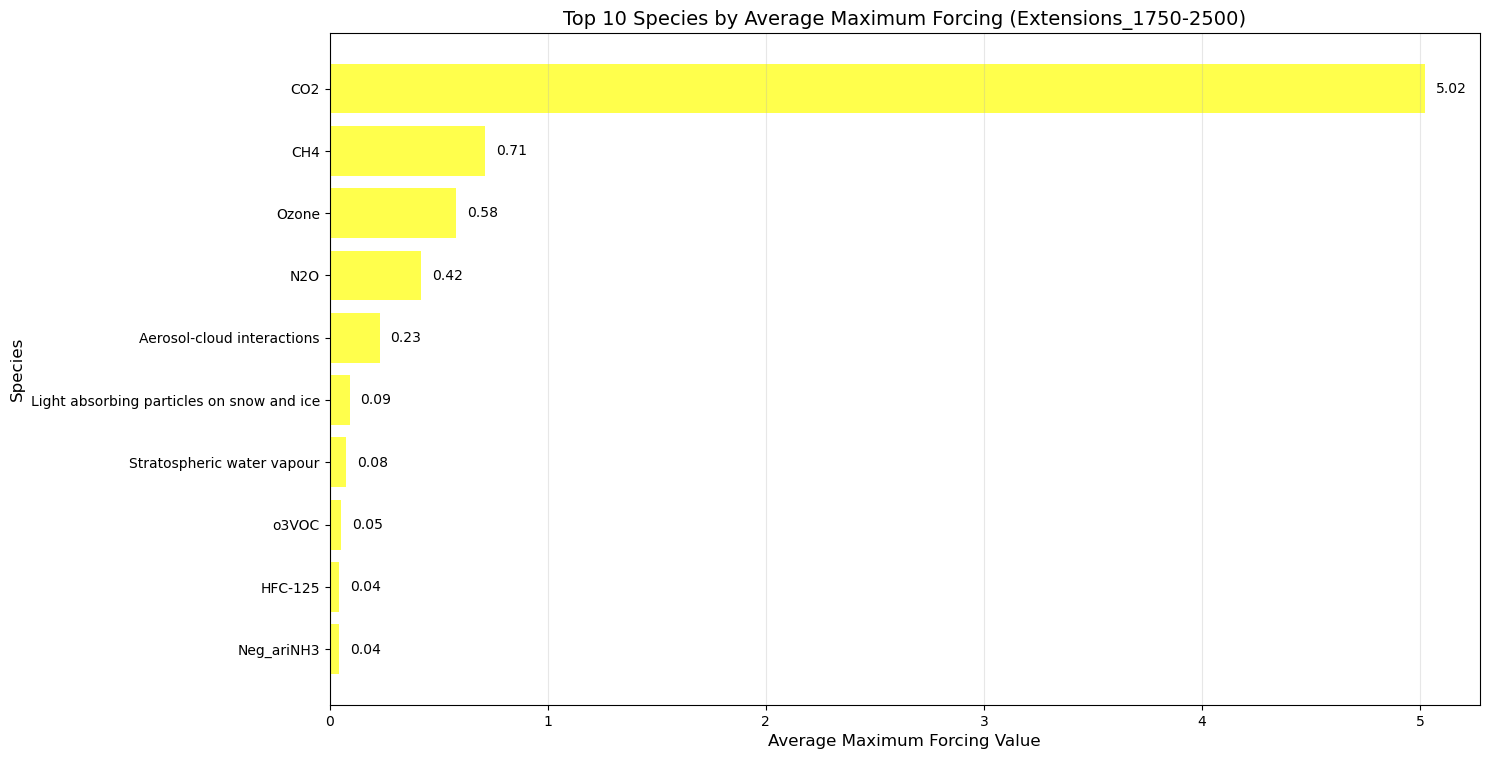

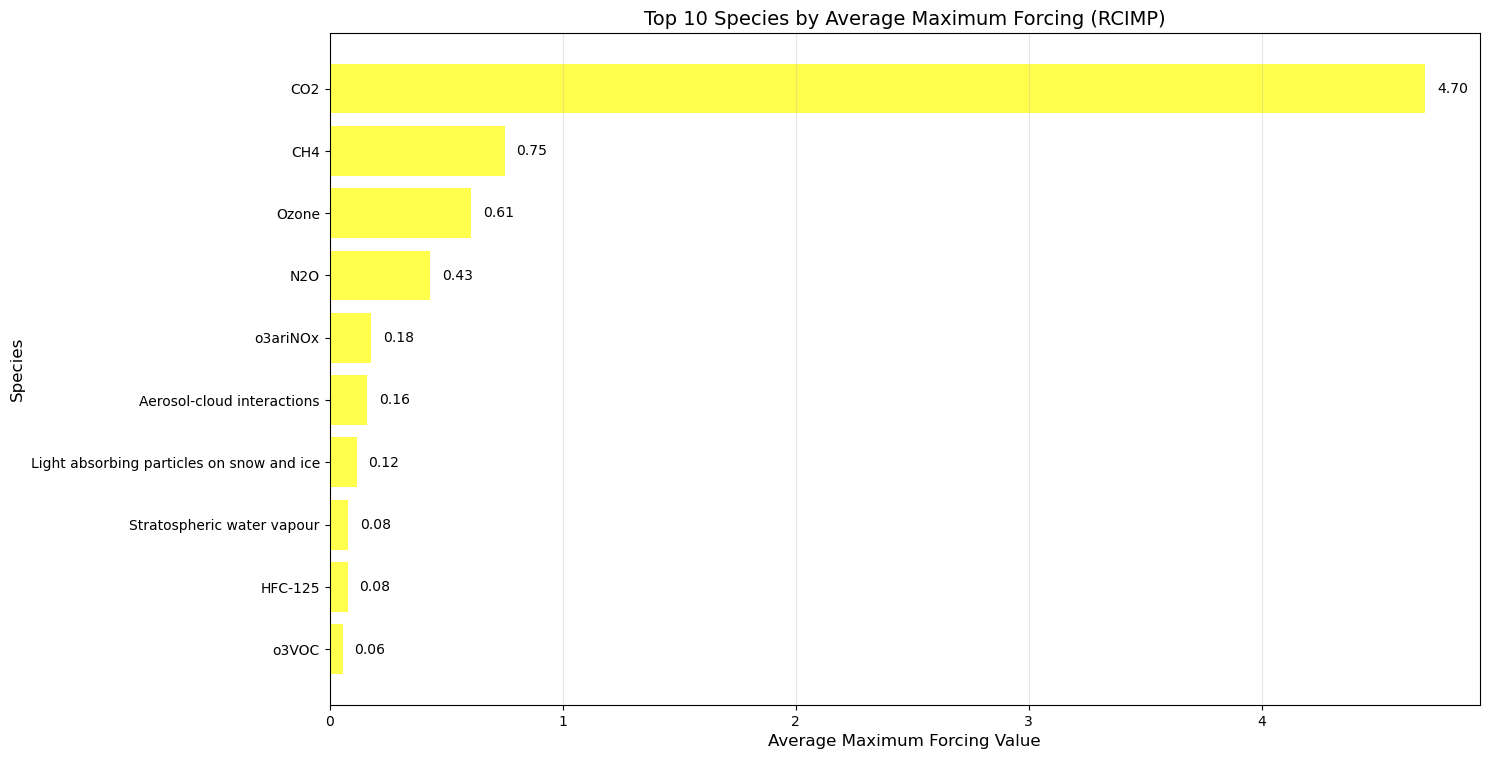

In [75]:
def ranking(forcing_df, max_threshold, cv_threshold, output_number = 100000000):

    forcing_df = forcing_df[forcing_df['mean_max_forcing'] > max_threshold]
    forcing_df = forcing_df[forcing_df['cv_by_scenario'] > cv_threshold]

    return forcing_df.sort_values("mean_max_forcing", ascending = False).head(output_number)

ranked_df_cali = ranking(summary_cali.copy(), 0.000000001, 0.00000000001)
ranked_df_rcimp = ranking(summary_rcimp.copy(), 0.000000001, 0.00000000001)
plot_top(ranked_df_cali, 10, '(Extensions_1750-2500)')
plot_top(ranked_df_rcimp, 10, '(RCIMP)')

# (unused)Max Forcing Calculation

In [ ]:
def array_to_dict(specie_array, scenario_array):
    output = {}
    index = 0
    for scenario in scenario_array:
        output[scenario] = specie_array[:, index, :]
        index += 1
    return output

ariNH3_dict = array_to_dict(ariNH3, scenarios_Rcimp)
o3CO_dict = array_to_dict(o3CO, scenarios_Rcimp)
o3VOC_dict = array_to_dict(o3VOC, scenarios_Rcimp)
o3ariNOx_dict = array_to_dict(o3ariNOx, scenarios_Rcimp)

In [ ]:
def array_forcing(specie_array, scenario_array, model):
    # returns tuple of max_forcing dict, and standard deviation for each scenario
    output = {}
    std_scenario = {}
    scenario_index = 0
    for scenario in scenario_array:
        max_forcing_array = []
        max_year_array = []
        for config in range(np.shape(specie_array)[2]):
            
            max_config_forcing = specie_array[:, scenario_index, config].max()
            max_forcing_array.append(max_config_forcing)
            
            max_config_index = specie_array[:, scenario_index, config].argmax()
            max_year = model.timepoints[max_config_index]
            max_year_array.append(max_year)
            
        max_forcing_array = np.array(max_forcing_array)
        std_scenario[scenario] = float(np.std(max_forcing_array))
        output[scenario] = float(np.average(max_forcing_array)), float(min(max_year_array)), float(max(max_year_array))
        scenario_index += 1

    return output, std_scenario

# dict: {scenario: max forcing, max year min, max year max}
ariNH3_maxforcing_dict = array_forcing(ariNH3, scenarios_Rcimp, f)[0]
ariNH3_maxforcing_std = array_forcing(ariNH3, scenarios_Rcimp, f)[1]
o3CO_maxforcing_dict = array_forcing(o3CO, scenarios_Rcimp, f)[0]
o3CO_maxforcing_std = array_forcing(o3CO, scenarios_Rcimp, f)[1]
o3VOC_maxforcing_dict = array_forcing(o3VOC, scenarios_Rcimp, f)[0]
o3VOC_maxforcing_std = array_forcing(o3VOC, scenarios_Rcimp, f)[1]
o3ariNOx_maxforcing_dict = array_forcing(o3ariNOx, scenarios_Rcimp, f)[0]
o3ariNOx_maxforcing_std = array_forcing(o3ariNOx, scenarios_Rcimp, f)[1]

In [ ]:
def forcing_writein(forcing_dict, forcing_df, specie_name):
    for scenario in forcing_dict.keys():
        # Check if the combination exists
        mask = (forcing_df['scenario'] == scenario) & (forcing_df['specie'] == specie_name)
        if mask.any():
            # Update existing rows
            forcing_df.loc[mask, 'max_forcing'] = forcing_dict[scenario]
        else:
            # Create a new row
            new_row = {'scenario': scenario, 'specie': specie_name, 'max_forcing': forcing_dict[scenario]}
            forcing_df = pd.concat([forcing_df, pd.DataFrame([new_row])], ignore_index=True)
    return forcing_df



max_forcing_df_Rcimp = forcing_writein(ariNH3_maxforcing_dict, max_forcing_df_Rcimp, 'ariNH3')
max_forcing_df_Rcimp = forcing_writein(o3CO_maxforcing_dict, max_forcing_df_Rcimp, 'o3CO')
max_forcing_df_Rcimp = forcing_writein(o3VOC_maxforcing_dict, max_forcing_df_Rcimp, 'o3VOC')
max_forcing_df_Rcimp = forcing_writein(o3ariNOx_maxforcing_dict, max_forcing_df_Rcimp, 'o3ariNOx')


#max_forcing_df_Rcimp.to_csv('examples/data/calibrated_constrained_ensemble/max_forcing_Rcimp.csv')
max_forcing_df_Rcimp
#max_forcing_df_Rcimp[max_forcing_df_Rcimp['specie'] == 'o3VOC']


